<a href="https://colab.research.google.com/github/UdayKiranVanapalli/Nifty-50-Price-Prediction-Application-/blob/main/SHORT%20TERM%20GAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 SCALPER STRATEGY - 2 DAY BREAKOUT MODE
Paste Yahoo Finance history links to analyze stocks
Type 'exit' or 'quit' to stop

📊 Enter Yahoo Finance Link (or 'exit'): https://finance.yahoo.com/quote/STARHEALTH.NS/history/?period1=1639107900&period2=1763111056

📈 ANALYZING: STARHEALTH.NS
📅 Period: 2021-12-10 to 2025-11-14
🎯 Strategy: 2 Day Breakout (LONG ONLY)
❌ Stop Loss: 2%
✅ Trailing: 5% → 5% trail
Fetching data for STARHEALTH.NS...
Data fetched: 970 rows

🔍 Finding scalper signals (2 day breakout window)...
✅ Total signals: 17

📋 FIRST 5 SIGNALS:
              Master_Date               Signal_Date                Entry_Date  Entry_Price  Breakout_Day
2022-01-07 00:00:00+05:30 2022-01-10 00:00:00+05:30 2022-01-12 00:00:00+05:30   804.000000             2
2022-01-14 00:00:00+05:30 2022-01-17 00:00:00+05:30 2022-01-18 00:00:00+05:30   861.000000             1
2022-02-25 00:00:00+05:30 2022-02-28 00:00:00+05:30 2022-03-03 00:00:00+05:30   703.500000             2
2022-03-30 00:00:00+05:30 2

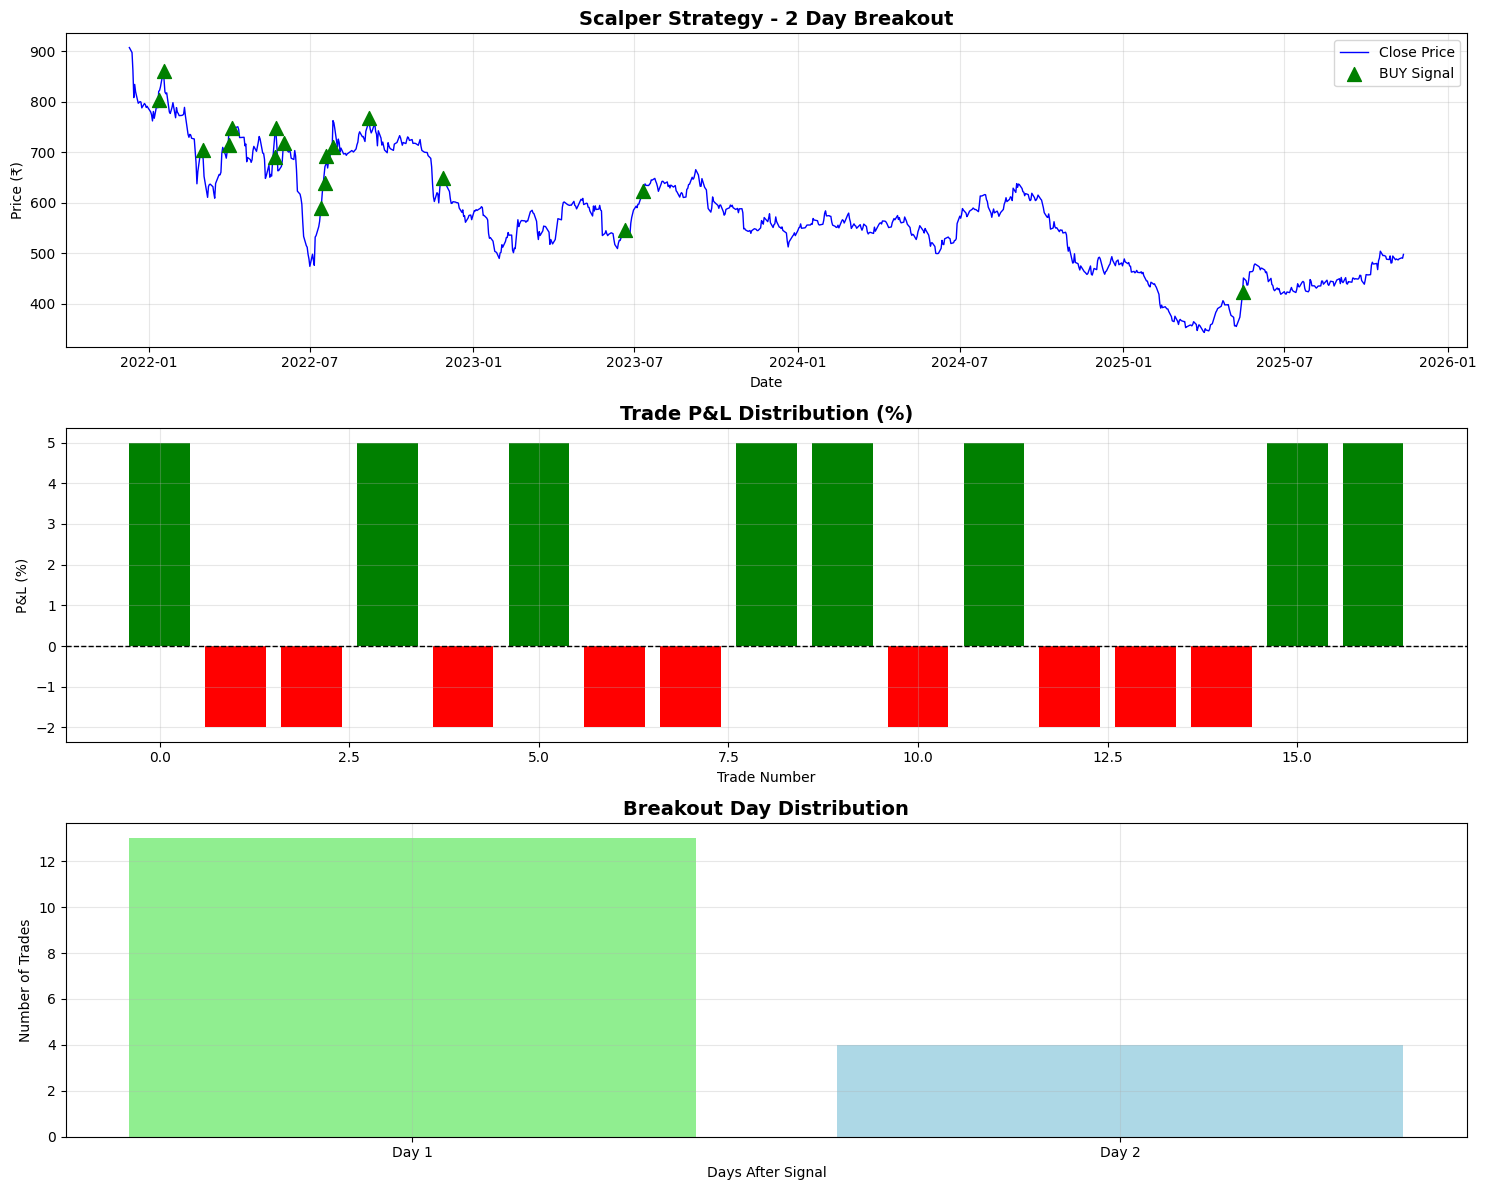


✅ Exported: STARHEALTH.NS_scalper_signals.csv, STARHEALTH.NS_scalper_trades.csv



In [ ]:
"""
SCALPER STRATEGY BACKTEST - LONG ONLY (2 DAY BREAKOUT)
Entry: When HIGH breaks signal candle HIGH within next 2 days
"""

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    """Fetch stock data from Yahoo Finance"""
    print(f"Fetching data for {ticker}...")
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)
    print(f"Data fetched: {len(df)} rows")
    return df

# Calculate Buy/Sell Levels
def calculate_levels(price):
    """Calculate buy and sell levels based on digit sum logic"""
    int_price = int(price)
    digit_sum = sum(int(d) for d in str(int_price))
    digit_count = len(str(int_price))

    buy_level = int_price + digit_sum + digit_count
    sell_level = int_price - digit_sum - digit_count

    return buy_level, sell_level, digit_sum, digit_count

# Check Gap Condition
def check_gap_condition(current, master, buffer_percent=0.1):
    """Check if current candle overlaps with master candle"""
    buffer = buffer_percent / 100
    master_high_buffer = master['High'] * (1 + buffer)
    master_low_buffer = master['Low'] * (1 - buffer)

    no_gap = (current['Low'] <= master_high_buffer) and (current['High'] >= master_low_buffer)
    return no_gap

# Find Scalper Signals - 2 DAY BREAKOUT
def find_scalper_signals(df, gap_buffer=0.1):
    """
    Find scalper signals:
    1. Master candle (previous) is GREEN
    2. Signal candle reaches buy level
    3. No gap between master and signal
    4. Entry when HIGH breaks signal candle HIGH within next 2 days
    """
    signals = []

    for i in range(1, len(df) - 2):  # Need at least 2 candles ahead
        master_candle = df.iloc[i - 1]
        signal_candle = df.iloc[i]

        # Check if master candle is GREEN
        is_master_green = master_candle['Close'] > master_candle['Open']
        if not is_master_green:
            continue

        # Calculate buy level from master candle
        buy_level, sell_level, digit_sum, digit_count = calculate_levels(master_candle['Close'])

        # Check if signal candle reaches buy level
        if signal_candle['Close'] < buy_level:
            continue

        # Check gap condition
        if not check_gap_condition(signal_candle, master_candle, gap_buffer):
            continue

        # Check next 2 days for breakout
        entry_triggered = False
        entry_date = None
        entry_price = None
        breakout_day = None

        for j in range(1, min(3, len(df) - i)):  # Next 2 days
            next_candle = df.iloc[i + j]

            if next_candle['High'] > signal_candle['High']:
                entry_triggered = True
                entry_date = next_candle['Date']
                entry_price = signal_candle['High']  # Enter at signal high
                breakout_day = j
                break

        if entry_triggered:
            signals.append({
                'Master_Date': master_candle['Date'],
                'Master_Close': master_candle['Close'],
                'Signal_Date': signal_candle['Date'],
                'Signal_High': signal_candle['High'],
                'Signal_Close': signal_candle['Close'],
                'Buy_Level': buy_level,
                'Digit_Sum': digit_sum,
                'Digit_Count': digit_count,
                'Entry_Date': entry_date,
                'Entry_Price': entry_price,
                'Breakout_Day': breakout_day,
                'Gap_OK': True,
                'Signal_Index': i + breakout_day
            })

    return pd.DataFrame(signals)

# Calculate Performance with Trailing Stop
def calculate_performance(df, signals_df, holding_period=5, stop_loss_pct=2,
                         target_pct=5, trailing_pct=5):
    """
    Calculate performance:
    - Initial Stop Loss: 2%
    - Trailing activates after 5% profit
    - Trailing stop: 5% below highest
    """

    if len(signals_df) == 0:
        return None, None

    trades = []

    for idx, signal in signals_df.iterrows():
        entry_idx = signal['Signal_Index']
        entry_price = signal['Entry_Price']

        # Define exit conditions
        stop_loss = entry_price * (1 - stop_loss_pct / 100)
        target_trigger = entry_price * (1 + target_pct / 100)

        exit_price = None
        exit_date = None
        exit_reason = None
        trailing_activated = False
        highest_price = entry_price
        trailing_stop = None

        # Check next candles for exit
        for j in range(entry_idx + 1, min(entry_idx + holding_period + 1, len(df))):
            candle = df.iloc[j]

            # Update highest price
            if candle['High'] > highest_price:
                highest_price = candle['High']

            # Activate trailing stop at 5%
            if not trailing_activated and candle['High'] >= target_trigger:
                trailing_activated = True
                trailing_stop = target_trigger
                exit_reason = 'Trailing Activated at 5%'

            # Update trailing stop
            if trailing_activated:
                new_trailing_stop = highest_price * (1 - trailing_pct / 100)
                if new_trailing_stop > trailing_stop:
                    trailing_stop = new_trailing_stop

            # Check stop loss
            if not trailing_activated and candle['Low'] <= stop_loss:
                exit_price = stop_loss
                exit_date = candle['Date']
                exit_reason = 'Stop Loss (2%)'
                break

            # Check trailing stop
            if trailing_activated and candle['Low'] <= trailing_stop:
                exit_price = trailing_stop
                exit_date = candle['Date']
                exit_reason = f'Trailing Stop (5% from ₹{highest_price:.2f})'
                break

        # Time exit
        if exit_price is None:
            exit_idx = min(entry_idx + holding_period, len(df) - 1)
            exit_candle = df.iloc[exit_idx]
            exit_price = exit_candle['Close']
            exit_date = exit_candle['Date']
            exit_reason = 'Time Exit'

        # Calculate P&L
        pnl = exit_price - entry_price
        pnl_pct = (pnl / entry_price) * 100

        trades.append({
            'Entry_Date': signal['Entry_Date'],
            'Entry_Price': entry_price,
            'Breakout_Day': signal['Breakout_Day'],
            'Exit_Date': exit_date,
            'Exit_Price': exit_price,
            'Exit_Reason': exit_reason,
            'Highest_Price': highest_price,
            'Trailing_Activated': trailing_activated,
            'P&L': pnl,
            'P&L_%': pnl_pct,
            'Winner': pnl > 0
        })

    trades_df = pd.DataFrame(trades)

    # Summary statistics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['Winner']])
    losing_trades = total_trades - winning_trades
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0

    avg_win = trades_df[trades_df['Winner']]['P&L_%'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[~trades_df['Winner']]['P&L_%'].mean() if losing_trades > 0 else 0

    # Breakout day analysis
    day1_breakouts = len(trades_df[trades_df['Breakout_Day'] == 1])
    day2_breakouts = len(trades_df[trades_df['Breakout_Day'] == 2])

    summary = {
        'Total_Trades': total_trades,
        'Winning_Trades': winning_trades,
        'Losing_Trades': losing_trades,
        'Win_Rate_%': win_rate,
        'Avg_Win_%': avg_win,
        'Avg_Loss_%': avg_loss,
        'Total_P&L_%': trades_df['P&L_%'].sum(),
        'Avg_P&L_%': trades_df['P&L_%'].mean(),
        'Day1_Breakouts': day1_breakouts,
        'Day2_Breakouts': day2_breakouts
    }

    return trades_df, summary

# Visualization
def plot_results(df, signals_df, trades_df):
    """Plot stock price with signals and performance"""

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    # Plot 1: Stock Price with Signals
    ax1.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=1)

    if len(signals_df) > 0:
        ax1.scatter(signals_df['Entry_Date'], signals_df['Entry_Price'],
                   color='green', marker='^', s=100, label='BUY Signal', zorder=5)

    ax1.set_title('Scalper Strategy - 2 Day Breakout', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (₹)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Trade P&L Distribution
    if trades_df is not None and len(trades_df) > 0:
        colors = ['green' if x > 0 else 'red' for x in trades_df['P&L_%']]
        ax2.bar(range(len(trades_df)), trades_df['P&L_%'], color=colors)
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax2.set_title('Trade P&L Distribution (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('P&L (%)')
        ax2.grid(True, alpha=0.3)

        # Plot 3: Breakout Day Analysis
        breakout_counts = trades_df['Breakout_Day'].value_counts().sort_index()
        ax3.bar(breakout_counts.index, breakout_counts.values, color=['lightgreen', 'lightblue'])
        ax3.set_title('Breakout Day Distribution', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Days After Signal')
        ax3.set_ylabel('Number of Trades')
        ax3.set_xticks([1, 2])
        ax3.set_xticklabels(['Day 1', 'Day 2'])
        ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":

    print("="*80)
    print("🚀 SCALPER STRATEGY - 2 DAY BREAKOUT MODE")
    print("="*80)
    print("Paste Yahoo Finance history links to analyze stocks")
    print("Type 'exit' or 'quit' to stop")
    print("="*80)

    while True:
        print("\n" + "="*80)
        yahoo_link = input("📊 Enter Yahoo Finance Link (or 'exit'): ").strip()

        if yahoo_link.lower() in ['exit', 'quit', 'q', '']:
            print("\n✅ Analysis complete!")
            break

        if 'finance.yahoo.com' not in yahoo_link:
            print("❌ Invalid link!")
            continue

        try:
            # Extract ticker
            ticker_match = re.search(r'/quote/([^/]+)/', yahoo_link)
            TICKER = ticker_match.group(1) if ticker_match else "UNKNOWN"

            # Extract dates
            period1_match = re.search(r'period1=(\d+)', yahoo_link)
            period2_match = re.search(r'period2=(\d+)', yahoo_link)

            if period1_match and period2_match:
                START_DATE = datetime.fromtimestamp(int(period1_match.group(1))).strftime('%Y-%m-%d')
                END_DATE = datetime.fromtimestamp(int(period2_match.group(1))).strftime('%Y-%m-%d')
            else:
                from datetime import timedelta
                END_DATE = datetime.now().strftime('%Y-%m-%d')
                START_DATE = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')

            # Parameters
            GAP_BUFFER = 0.1
            HOLDING_PERIOD = 10
            STOP_LOSS = 2
            TRAILING_TRIGGER = 5
            TRAILING_PERCENT = 5

            print("\n" + "="*80)
            print(f"📈 ANALYZING: {TICKER}")
            print(f"📅 Period: {START_DATE} to {END_DATE}")
            print("="*80)
            print(f"🎯 Strategy: 2 Day Breakout (LONG ONLY)")
            print(f"❌ Stop Loss: {STOP_LOSS}%")
            print(f"✅ Trailing: {TRAILING_TRIGGER}% → {TRAILING_PERCENT}% trail")
            print("="*80)

            # Fetch data
            df = fetch_stock_data(TICKER, START_DATE, END_DATE)

            # Find signals
            print("\n🔍 Finding scalper signals (2 day breakout window)...")
            signals_df = find_scalper_signals(df, GAP_BUFFER)
            print(f"✅ Total signals: {len(signals_df)}")

            if len(signals_df) == 0:
                print("\n⚠️ No signals found!")
                print("Reasons: No GREEN master → buy level → 2-day breakout")
                continue_choice = input("\nAnalyze another? (y/n): ").strip().lower()
                if continue_choice != 'y':
                    break
                continue

            # Display signals
            print("\n" + "="*80)
            print("📋 FIRST 5 SIGNALS:")
            print("="*80)
            display_cols = ['Master_Date', 'Signal_Date', 'Entry_Date', 'Entry_Price', 'Breakout_Day']
            print(signals_df[display_cols].head(5).to_string(index=False))

            # Calculate performance
            print("\n⚙️ Calculating performance...")
            trades_df, summary = calculate_performance(df, signals_df, HOLDING_PERIOD,
                                                      STOP_LOSS, TRAILING_TRIGGER, TRAILING_PERCENT)

            # Display summary
            print("\n" + "="*80)
            print(f"📊 PERFORMANCE SUMMARY - {TICKER}")
            print("="*80)
            for key, value in summary.items():
                if isinstance(value, float):
                    print(f"  {key}: {value:.2f}")
                else:
                    print(f"  {key}: {value}")

            # Best/Worst trades
            if len(trades_df) > 0:
                best = trades_df.loc[trades_df['P&L_%'].idxmax()]
                worst = trades_df.loc[trades_df['P&L_%'].idxmin()]

                print("\n" + "-"*80)
                print("🏆 BEST TRADE:")
                print(f"  Entry: {best['Entry_Date']} @ ₹{best['Entry_Price']:.2f}")
                print(f"  Exit: {best['Exit_Date']} @ ₹{best['Exit_Price']:.2f}")
                print(f"  P&L: {best['P&L_%']:.2f}% | Day {best['Breakout_Day']} breakout")

                print("\n💀 WORST TRADE:")
                print(f"  Entry: {worst['Entry_Date']} @ ₹{worst['Entry_Price']:.2f}")
                print(f"  Exit: {worst['Exit_Date']} @ ₹{worst['Exit_Price']:.2f}")
                print(f"  P&L: {worst['P&L_%']:.2f}% | Day {worst['Breakout_Day']} breakout")
                print("-"*80)

            # Show details
            show_details = input("\n📋 Show all trades? (y/n): ").strip().lower()
            if show_details == 'y':
                print("\n" + "="*80)
                print("📋 ALL TRADES:")
                print("="*80)
                cols = ['Entry_Date', 'Entry_Price', 'Breakout_Day', 'Exit_Date', 'Exit_Price', 'P&L_%']
                print(trades_df[cols].to_string(index=False))

            # Plot
            show_plot = input("\n📈 Generate charts? (y/n): ").strip().lower()
            if show_plot == 'y':
                plot_results(df, signals_df, trades_df)

            # Export
            csv_signals = f'{TICKER}_scalper_signals.csv'
            csv_trades = f'{TICKER}_scalper_trades.csv'
            signals_df.to_csv(csv_signals, index=False)
            trades_df.to_csv(csv_trades, index=False)
            print(f"\n✅ Exported: {csv_signals}, {csv_trades}")

        except Exception as e:
            print(f"\n❌ Error: {str(e)}")

        print("\n" + "="*80)
        continue_choice = input("Analyze another? (y/n): ").strip().lower()
        if continue_choice != 'y':
            break

    print("\n" + "="*80)
    print("Thank you! 🚀")
    print("="*80)